In [4]:
import pennylane as qml
import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

# Feedback-Based Quantum Optimization (FALQON)

We will be solving the Maximum Clique problem for the following graph:

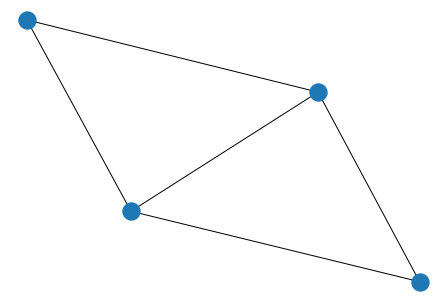

In [73]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (3, 1)]
graph = nx.Graph(edges)
nx.draw(graph)

We will be investigating the MaxClique problem, which has a cost Hamiltonian of the form:
    
$$H_C = 3 \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) + \displaystyle\sum_{i \in V(G)} Z_i$$

and a mixer of the form:

$$H_{M} = \displaystyle\sum_{i \in V(G)} X_i$$

In [74]:
cost_h, mixer_h = qaoa.max_clique(graph)

In order to implement FALQON, we must calculate the commutator of the Hamiltonians $H_C$ and $H_M$. We will have:

$$[H_M, H_C] = \Big[ \displaystyle\sum_{i} X_i, 3 \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) + \displaystyle\sum_{i \in V(G)} Z_i \Big] = 3 \Big[ \displaystyle\sum_{i} X_i, \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) \Big] + 3 \Big[ \displaystyle\sum_{i} X_i, \displaystyle\sum_{i} Z_i \Big]$$
$$= 3 \displaystyle\sum_{k} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( [X_k, Z_i Z_j] - [X_k, Z_i] - [X_k, Z_j] \big) + 3 \displaystyle\sum_{i} \displaystyle\sum_{j} [X_i, Z_j]$$

It follows that there are two commutators of interest: $[X_i, Z_j]$ and $[X_k, Z_i Z_j]$. There commutators are given by rules for Pauli matrices:

$$[X_i, Z_j] = 2 i \delta_{ij} Y_i \ \ \ \text{and} \ \ \ [X_k, Z_i Z_j] = 2 i \delta_{ik} Y_k Z_j + 2i \delta_{jk} Z_i Y_k$$

Therefore:

$$3 \displaystyle\sum_{k} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( [X_k, Z_i Z_j] - [X_k, Z_i] - [X_k, Z_j] \big) + 3 \displaystyle\sum_{i} \displaystyle\sum_{j} [X_i, Z_j] = 
6i \displaystyle\sum_{k} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( \delta_{ki} Y_k Z_j + \delta_{kj} Z_{i} Y_{k} - \delta_{ki} Y_k - \delta_{kj} Y_k \big) + \text{other stuff that I'm too lazy to write right now}$$

This allows us to define a method which calculates the above commutator, for a given graph:

In [75]:
def build_commutator(graph):
    
    H = qml.Hamiltonian([], [])
    
    # Computes the first sum
    graph_c = nx.complement(graph)
    
    for k in graph_c.nodes:
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) - qml.PauliY(k) @ qml.PauliZ(j))
            if k == j:
                H += 6 * (qml.PauliY(k) - qml.PauliZ(i) @ qml.PauliY(k))
        H += 6 * qml.PauliY(k)
    
    return H

print(build_commutator(graph))

  (6) [Y1]
+ (6) [Y2]
+ (12) [Y0]
+ (12) [Y3]
+ (-6) [Y0 Z3]
+ (-6) [Z0 Y3]


In addition to defining the commutator $i [H_M, H_C]$, we write a method which defines a layer of the FALQON circuit:

In [95]:
# Define a layer of the Falqon circuit
delta_t = 0.05

def falqon_layer(beta):
    qaoa.cost_layer(delta_t, cost_h)
    qaoa.mixer_layer(delta_t * beta, mixer_h)

Next, we can define the device, the Hamiltonian, and a method which builds our ansatz to a desired depth:

In [96]:
dev = qml.device("default.qubit", wires=graph.nodes)
hamiltonian = build_commutator(graph)

def ansatz(beta, **kwargs):
    layers = len(beta)
    for w in dev.wires:
        qml.Hadamard(wires=w)
    qml.layer(falqon_layer, layers, beta)

In [97]:
def falqon(iterations, beta_init):
    
    beta = [beta_init]
    
    for i in range(iterations):
        cost_fn = qml.ExpvalCost(ansatz, hamiltonian, dev)
        beta.append(-1 * cost_fn(beta))
        print("Step {} Done, Beta = {}".format(i, beta))
    
    return beta

res = falqon(20, 0.0)

Step 0 Done, Beta = [0.0, -3.5940029992858045]
Step 1 Done, Beta = [0.0, -3.5940029992858045, -2.7661250438793683]
Step 2 Done, Beta = [0.0, -3.5940029992858045, -2.7661250438793683, -2.653886506751849]
Step 3 Done, Beta = [0.0, -3.5940029992858045, -2.7661250438793683, -2.653886506751849, -2.4022319797736262]
Step 4 Done, Beta = [0.0, -3.5940029992858045, -2.7661250438793683, -2.653886506751849, -2.4022319797736262, -2.232349860857672]
Step 5 Done, Beta = [0.0, -3.5940029992858045, -2.7661250438793683, -2.653886506751849, -2.4022319797736262, -2.232349860857672, -2.060187641144939]
Step 6 Done, Beta = [0.0, -3.5940029992858045, -2.7661250438793683, -2.653886506751849, -2.4022319797736262, -2.232349860857672, -2.060187641144939, -1.9272221212635205]
Step 7 Done, Beta = [0.0, -3.5940029992858045, -2.7661250438793683, -2.653886506751849, -2.4022319797736262, -2.232349860857672, -2.060187641144939, -1.9272221212635205, -1.8062156207509559]
Step 8 Done, Beta = [0.0, -3.5940029992858045, -2

Now, we can test the results from the experiment:

<BarContainer object of 16 artists>

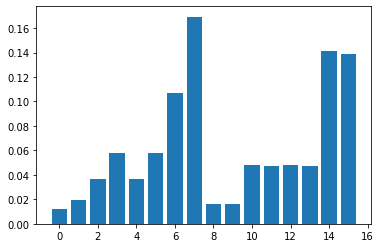

In [89]:
@qml.qnode(dev)
def test_circuit():
    ansatz(re)
    return qml.probs(wires=dev.wires)

probs = test_circuit()
plt.bar(range(2**len(dev.wires)), probs)